# Imports

In [1]:
import os
import numpy as np
import tensorflow
import librosa
import pandas as pd

from tensorflow import keras
from matplotlib import pyplot as plt
from scikeras.wrappers import KerasClassifier, KerasRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

2024-05-18 03:16:05.879794: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#! unzip genres.zip -d GTZAN-Dataset

# Functions and Variables

In [3]:
random_state = 8

gtzan_directory = 'GTZAN-Dataset/genres/'
all_gtzan_genres = [genre for genre in os.listdir(gtzan_directory)]
testing_genres = ['classical', 'hiphop', 'reggae']
testing_genres2 = ['classical', 'jazz', 'country']

sample_file = 'GTZAN-Dataset/genres/hiphop/hiphop.00095.au'

## Features

In [4]:
def calculate_mfcc(y, sampling_rate):
    """
    Calculate mel-frequency cepstral coefficients,
        logarithmic. Capture character of sound.
    """
    mfcc = np.array(librosa.feature
                    .mfcc(y=y, sr=sampling_rate))
    return mfcc


def calculate_melspectrogram(y, sampling_rate):
    """
    Mel Spectrogram, calculating pitch over time.
    """
    melspectrogram = np.array(librosa.feature
                              .melspectrogram(y=y, sr=sampling_rate))
    return melspectrogram


def calculate_chromavector(y, sampling_rate):
    """
    Chroma Vector, interpreting musical note appearances.
    """
    chroma = np.array(librosa.feature
                     .chroma_stft(y=y, sr=sampling_rate))
    return chroma


def calculate_tonnetz(y, sampling_rate):
    """
    Tonal centroid, calculating central features
        of sound.
    """
    tonnetz = np.array(librosa.feature.
                      tonnetz(y=y, sr=sampling_rate))
    return tonnetz


def calculate_bpm(y, sampling_rate):
    """
    Beats per minute, returns estimated bpm.
    """
    bpm = np.array(librosa.feature
                   .rhythm
                   .tempo(y=y, sr=sampling_rate))#, aggregate=None))
    return bpm


def calculate_zcr(y, sampling_rate):
    zcr = librosa.feature \
                 .zero_crossing_rate(y=y)
    return zcr


def calculate_tempogram(y, sampling_rate):
    tempogram = librosa.feature \
                       .tempogram(y=y, sr=sampling_rate)
    return tempogram

## Extract Features

In [5]:
def parse_genres(genres, directory):
    """
    Create genre labels, genre features np arrays
        for ML processing.
    Returns: labels, features.
    """
    labels = []
    features = []
    i = 0
    for genre in genres:
        i+=1
        print(f'Calculating features for {genre}... ({i}/{len(genres)})')
        for file in os.listdir(directory+genre):
            filepath = directory+genre+'/'+file
            features.append(streamline_features(filepath))
            label = genres.index(genre)
            labels.append(label)
    labels, features = np.array(labels), \
                       np.array(features)
    print('\n ~ Genre calculations complete ~')
    return labels, features


def streamline_features(filepath):
    """
    Calculate chosen features of `filepath`.
    """
    # MFCC Features
    mfcc = extract_features(filepath, 
                            calculate_mfcc)
    
    # Mel Spectrogram Features
    melspectro = extract_features(filepath, 
                                  calculate_melspectrogram)
    
    # Chroma Vector Features
    chromavector = extract_features(filepath, 
                                    calculate_chromavector)
    
    # Tonal Centroid Features
    tonnetz = extract_features(filepath, 
                               calculate_tonnetz)
    
    # BPM Features
    bpm = extract_features(filepath, 
                           calculate_bpm, axis=0)
    
    # ZCR Features
    zcr = extract_features(filepath, 
                            calculate_zcr)
    
    # Tempogram Features
    tempogram = extract_features(filepath, 
                            calculate_tempogram)
    
    # Concatenate features into np array
    all_features = np.concatenate((mfcc, melspectro, chromavector,
                                   tonnetz, bpm, zcr, tempogram))
    
    return all_features


def extract_features(filepath, extraction_func, axis=1, duration=30):
    """
    Return min, mean, max description of filepath features.
    Called from streamline_features.
    """
    y, sampling_rate = librosa.load(filepath, duration=duration)
    all_features = extraction_func(y, sampling_rate)
    
    if not axis < 1:
        feature_min, feature_mean, \
                      feature_max = all_features.min(axis=axis), \
                                    all_features.mean(axis=axis), \
                                    all_features.max(axis=axis)
        features = np.concatenate((feature_min, feature_mean,
                               feature_max))
    else:
        features = all_features 
        
    return features

## Training, Testing, and Validation Sets

In [6]:
def train_test_validation(labels, features, test_size=0.2,
                          seed=random_state):
    """
    Divides features and labels into training, validation,
        and testing sets.
    Returns: features training set, features validation set,
        features test set, labels training set, labels validation
        set, labels test set.
    """
    permutations = np.random \
                        .default_rng(seed=seed) \
                        .permutation(len(features))
    features = features[permutations]
    labels = labels[permutations]
    
    features_train, features_test, \
        labels_train, labels_test = train_test_split(features, 
                                            labels,
                                            test_size=test_size,
                                            random_state=seed)
    features_train, features_val, \
        labels_train, labels_val = train_test_split(features_train, 
                                            labels_train,
                                            test_size=test_size,
                                            random_state=seed)
    return features_train, features_val, \
            features_test, labels_train, \
            labels_val, labels_test

## Compile Model

In [165]:
def neural_network_processing(x_train, y_train, x_val, y_val, \
                              input_shape, output_size, \
                              epochs=40, dense1=100, dense2=80, dense3=70,
                              batch_size=16, optimizer='rmsprop',
                              dropout1=0.3, dropout2=0.2):
    """
    Use keras neural network with training, validation, and testing sets.
    Default relu activation function.
    """
    # Compile neural network
    inputs = keras.Input(shape=(input_shape,), name='feature')
    x1 = keras.layers.Dense(dense1, activation='relu', 
                           name='dense1')(inputs)
    d1 = keras.layers.Dropout(dropout1)(x1)
    x2 = keras.layers.Dense(dense2, activation='relu', 
                           name='dense2')(d1)
    d2 = keras.layers.Dropout(dropout2)(x2)
    x3 = keras.layers.Dense(dense3, activation='relu', 
                           name='dense3')(d2)
    outputs = keras.layers.Dense(input_shape, activation='softmax',
                                name='predictions')(x3)
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(#Optimiser
                    optimizer=optimizer,
                  #Loss Function to minimise
                    loss=keras.losses.SparseCategoricalCrossentropy(),
                  # Metrics to monitor
                    metrics=[keras.metrics.SparseCategoricalAccuracy()])

    model.fit(x=x_train, y=y_train,
             verbose=1, validation_data=(x_val,
             y_val), epochs=epochs, batch_size=batch_size)
    
    return model


def neural_network_model(input_shape, optimizer='adam', activation='relu', 
                         dense1=300, dense2=200, dropout1=0, dropout2=0):
    """
    Intended for Grid CV search using scikeras wrapper.
    
    Instantiate keras neural network with `input_shape`.
    Does not fit model.
    Default relu activation function.
    """
    # Compile neural network
    inputs = keras.Input(shape=(input_shape,), name='feature')
    x1 = keras.layers.Dense(dense1, activation='relu', 
                           name='dense1')(inputs)
    d1 = keras.layers.Dropout(dropout1)(x1)
    x2 = keras.layers.Dense(dense2, activation='relu', 
                           name='dense2')(d1)
    d2 = keras.layers.Dropout(dropout2)(x2)
    outputs = keras.layers.Dense(input_shape, activation='softmax',
                                name='predictions')(d2)
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(#Optimiser
                    optimizer=optimizer,
                  #Loss Function to minimise
                    loss=keras.losses.SparseCategoricalCrossentropy(),
                  # Metrics to monitor
                    metrics=[keras.metrics.SparseCategoricalAccuracy()])
    
    return model

## Parameter Grid Search

**WARNING: following Grid Search optimisation cell takes 1hr+ to run on full genre set.**

**Output on full_gtzan_genres training set as of 05/15:**

Best Parameters: {'activation': 'relu', 
                    'batch_size': 16, 
                    'dense1': 200, 
                    'dense2': 50, 
                    'epochs': 40, 
                    'input_shape': 1654, 
                    'optimizer': 'rmsprop'}

Best Accuracy: 0.5320813771517997


**Output on testing_genres test set as of 05/18:**

Best Parameters: {'activation': 'relu', 
                  'batch_size': 16, 
                  'dense1': 50, 
                  'dense2': 80, 
                  'dropout1': 0.5, 
                  'dropout2': 0.2, 
                  'epochs': 40, 
                  'input_shape': 1654, 
                  'optimizer': 'rmsprop'}
Best Accuracy: 0.8166666666666668

In [179]:
# ## CURRENTLY RUNS ON TEST SET.

# from scikeras.wrappers import KerasClassifier, KerasRegressor

# model = KerasClassifier(model=neural_network_model, epochs=10, 
#                         batch_size=32, verbose=0.1, activation='relu', 
#                         dense1=100, dense2=50, input_shape=[features_train.shape[1]],
#                         dropout1=0.1, dropout2=0.2)

# # Define hyperparameters to tune
# param_grid = {
#     'input_shape':[features_test.shape[1]],
#     'optimizer': ['rmsprop'],
#     'activation': ['relu'],
#     'batch_size': [16, 32],
#     'epochs': [40],
#     'dense1': [50, 100],
#     'dense2': [80, 150],
#     'dropout1': [0.3, 0.5],
#     'dropout2': [0.2]
# }

# # Use GridSearchCV to find the best combination of hyperparameters
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
# grid_result = grid.fit(features_test, labels_test)


In [85]:
# # Display the best hyperparameters and corresponding accuracy
# print(f"Best Parameters: {grid_result.best_params_}")
# print(f"Best Accuracy: {grid_result.best_score_}")

## Model Accuracy

In [178]:
def model_accuracy(model, x_train, y_train, \
                   x_val, y_val, \
                   x_test, y_test):
    """
    Calculate model accuracy using model.evaluate().
    """
    train_score = np.round(model.evaluate(x=x_train,
                                 y=y_train, 
                                 verbose=1)[1], 4)
    print(f'Training Accuracy: {np.round(train_score*100, 2)}%')
    
    val_score = np.round(model.evaluate(x=x_val,
                               y=y_val, 
                               verbose=1)[1], 4)
    print(f'Validation Accuracy: {np.round(val_score*100, 2)}%')

    test_score = np.round(model.evaluate(x=x_test,
                                y=y_test, 
                                verbose=1)[1], 4)
    print(f'Testing Accuracy: {np.round(test_score*100, 2)}%')
    
    return [train_score, val_score, test_score]


def model_iterations(i, selected_features, x_train, y_train, x_val, y_val, 
                      x_test, y_test, 
                      epochs=40, dense1=100, dense2=80, dense3=80,
                      batch_size=16, optimizer='rmsprop', dropout1=0.3, dropout2=0.2):
    """
    Returns average model validation and testing accuracies
        over i iterations.
    """
    train = []
    val = []
    test = []
    for _ in np.arange(i):
        model = neural_network_processing(x_train, y_train, x_val, y_val,
                                          selected_features.shape[1], len(genres), 
                                          batch_size=batch_size, optimizer=optimizer, 
                                          epochs=epochs, 
                                          dense1=dense1, dense2=dense2, dense3=dense3,
                                          dropout1=dropout1, dropout2=dropout2)
        accuracies = model_accuracy(model, x_train, y_train, \
                       x_val, y_val, \
                       x_test, y_test)
        train.append(accuracies[0])
        val.append(accuracies[1])
        test.append(accuracies[2])
        
    train_mean = np.round(np.mean(train), 2)
    val_mean = np.round(np.mean(val), 2)
    test_mean = np.round(np.mean(test), 2)
    
    return train_mean, val_mean, test_mean

# Modelling

## Three Genre Model

In [174]:
testing_genres = testing_genres

In [175]:
testing_labels, testing_features = parse_genres(testing_genres, gtzan_directory)

Calculating features for classical... (1/3)
Calculating features for hiphop... (2/3)
Calculating features for reggae... (3/3)

 ~ Genre calculations complete ~


In [176]:
testing_features_train, testing_features_val, \
  testing_features_test, testing_labels_train, \
  testing_labels_val, testing_labels_test = train_test_validation(testing_labels, testing_features)

In [177]:
testing_train_mean, testing_val_mean, testing_test_mean = model_iterations(15, features, testing_features_train, testing_labels_train,
                                       testing_features_val, testing_labels_val, testing_features_test, testing_labels_test)

Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 13.5717 - sparse_categorical_accuracy: 0.2481 - val_loss: 1.6572 - val_sparse_categorical_accuracy: 0.7500
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1185 - sparse_categorical_accuracy: 0.5447 - val_loss: 1.1700 - val_sparse_categorical_accuracy: 0.8125
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0920 - sparse_categorical_accuracy: 0.6084 - val_loss: 1.5214 - val_sparse_categorical_accuracy: 0.7917
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9641 - sparse_categorical_accuracy: 0.7339 - val_loss: 0.8277 - val_sparse_categorical_accuracy: 0.8542
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4888 - sparse_categorical_accuracy: 0.6464 - val_loss: 0.9700 - val_sparse_categorical_accuracy: 0.7917
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1962 - sparse_categorical_accuracy: 0.7009 - val_loss: 1.5112 - val_sparse_categorical_accuracy: 0.7292
Epoch 7/40


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.3047 - sparse_categorical_accuracy: 0.8229
Validation Accuracy: 81.25%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1341 - sparse_categorical_accuracy: 0.8049 
Testing Accuracy: 81.67%
Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 18.3916 - sparse_categorical_accuracy: 0.1909 - val_loss: 1.8513 - val_sparse_categorical_accuracy: 0.6875
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8382 - sparse_categorical_accuracy: 0.5814 - val_loss: 2.2552 - val_sparse_categorical_accuracy: 0.6875
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6551 - sparse_categorical_accuracy: 0.6854 - val_loss: 1.3434 - val_sparse_categorical_accuracy: 0.7083
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6392 - sparse_categorical_accuracy: 0.6821 - val_loss: 0.5259 - val_sparse_categorical_accuracy: 0.8542
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6725 - sparse_categorical_accuracy: 0.6132 - va

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1495 - sparse_categorical_accuracy: 0.9133 - val_loss: 1.0477 - val_sparse_categorical_accuracy: 0.8750
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0808 - sparse_categorical_accuracy: 0.9651  
Training Accuracy: 97.38%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0559 - sparse_categorical_accuracy: 0.8646
Validation Accuracy: 87.5%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4564 - sparse_categorical_accuracy: 0.6965 
Testing Accuracy: 71.67%
Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 13.2328 - sparse_categorical_accuracy: 0.2652 - val_loss: 0.7439 - val_sparse_categorical_accuracy: 0.7708
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0189 - sparse_categorical_accuracy: 0.6089 - val_loss: 0.9210 - val_sparse_categorical_accuracy: 0.7292
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7316 - sparse_categorical_accuracy: 0.6638 - val_loss: 0.5946 - val_sparse_categorical_accuracy: 0.7708
E

Epoch 39/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1867 - sparse_categorical_accuracy: 0.9136 - val_loss: 0.8592 - val_sparse_categorical_accuracy: 0.8542
Epoch 40/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2831 - sparse_categorical_accuracy: 0.9073 - val_loss: 0.5274 - val_sparse_categorical_accuracy: 0.8750
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1009 - sparse_categorical_accuracy: 0.9579  
Training Accuracy: 96.86%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5537 - sparse_categorical_accuracy: 0.8646
Validation Accuracy: 87.5%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0660 - sparse_categorical_accuracy: 0.6854 
Testing Accuracy: 70.0%
Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 15.5947 - sparse_categorical_accuracy: 0.2711 - val_loss: 2.2184 - val_sparse_categorical_accuracy: 0.5417
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0072 - sparse_categorical_accuracy: 0.4912 - val_loss: 1.4366 - val_sparse_categorical_accu

Epoch 38/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2429 - sparse_categorical_accuracy: 0.8949 - val_loss: 0.8606 - val_sparse_categorical_accuracy: 0.8333
Epoch 39/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1798 - sparse_categorical_accuracy: 0.9179 - val_loss: 1.1287 - val_sparse_categorical_accuracy: 0.8333
Epoch 40/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3144 - sparse_categorical_accuracy: 0.9057 - val_loss: 0.7962 - val_sparse_categorical_accuracy: 0.7917
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1218 - sparse_categorical_accuracy: 0.9530  
Training Accuracy: 95.81%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8497 - sparse_categorical_accuracy: 0.7882 
Validation Accuracy: 79.17%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1175 - sparse_categorical_accuracy: 0.7715 
Testing Accuracy: 76.67%
Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 24.1810 - sparse_categorical_accuracy: 0.1142 - val_loss: 1.4516 - val_sparse_categorical_acc

Epoch 37/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3734 - sparse_categorical_accuracy: 0.8575 - val_loss: 0.7773 - val_sparse_categorical_accuracy: 0.8750
Epoch 38/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2122 - sparse_categorical_accuracy: 0.8977 - val_loss: 0.9788 - val_sparse_categorical_accuracy: 0.8125
Epoch 39/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2588 - sparse_categorical_accuracy: 0.9125 - val_loss: 0.9839 - val_sparse_categorical_accuracy: 0.8125
Epoch 40/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2531 - sparse_categorical_accuracy: 0.9093 - val_loss: 0.9595 - val_sparse_categorical_accuracy: 0.8333
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1441 - sparse_categorical_accuracy: 0.9360  
Training Accuracy: 95.81%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0264 - sparse_categorical_accuracy: 0.8264 
Validation Accuracy: 83.33%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8648 - sparse_categorical_accuracy: 0.7396 
Testing Accu

Epoch 36/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2238 - sparse_categorical_accuracy: 0.9274 - val_loss: 1.2522 - val_sparse_categorical_accuracy: 0.7917
Epoch 37/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2515 - sparse_categorical_accuracy: 0.9081 - val_loss: 0.9503 - val_sparse_categorical_accuracy: 0.8542
Epoch 38/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3903 - sparse_categorical_accuracy: 0.8792 - val_loss: 0.7609 - val_sparse_categorical_accuracy: 0.8333
Epoch 39/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2608 - sparse_categorical_accuracy: 0.9526 - val_loss: 0.8759 - val_sparse_categorical_accuracy: 0.7917
Epoch 40/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2163 - sparse_categorical_accuracy: 0.9150 - val_loss: 0.8921 - val_sparse_categorical_accuracy: 0.8333
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1002 - sparse_categorical_accuracy: 0.9706  
Training Accuracy: 96.34%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9757 - spa

Epoch 35/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3208 - sparse_categorical_accuracy: 0.8997 - val_loss: 0.7333 - val_sparse_categorical_accuracy: 0.7917
Epoch 36/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3903 - sparse_categorical_accuracy: 0.8517 - val_loss: 0.6848 - val_sparse_categorical_accuracy: 0.7917
Epoch 37/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1641 - sparse_categorical_accuracy: 0.9225 - val_loss: 0.8407 - val_sparse_categorical_accuracy: 0.7917
Epoch 38/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3213 - sparse_categorical_accuracy: 0.9026 - val_loss: 0.9277 - val_sparse_categorical_accuracy: 0.7917
Epoch 39/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1630 - sparse_categorical_accuracy: 0.9403 - val_loss: 0.6892 - val_sparse_categorical_accuracy: 0.8333
Epoch 40/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1995 - sparse_categorical_accuracy: 0.9229 - val_loss: 0.5969 - val_sparse_categorical_accuracy: 0.8125
6/6 ━━━

Epoch 34/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2748 - sparse_categorical_accuracy: 0.8970 - val_loss: 0.5403 - val_sparse_categorical_accuracy: 0.8125
Epoch 35/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4813 - sparse_categorical_accuracy: 0.8475 - val_loss: 0.7959 - val_sparse_categorical_accuracy: 0.8333
Epoch 36/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2762 - sparse_categorical_accuracy: 0.8885 - val_loss: 0.7805 - val_sparse_categorical_accuracy: 0.8333
Epoch 37/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2708 - sparse_categorical_accuracy: 0.9426 - val_loss: 0.6819 - val_sparse_categorical_accuracy: 0.8333
Epoch 38/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2605 - sparse_categorical_accuracy: 0.9121 - val_loss: 0.8470 - val_sparse_categorical_accuracy: 0.7917
Epoch 39/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3710 - sparse_categorical_accuracy: 0.8693 - val_loss: 0.7784 - val_sparse_categorical_accuracy: 0.7917
Epoch 40/4

Epoch 33/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2243 - sparse_categorical_accuracy: 0.9253 - val_loss: 0.9084 - val_sparse_categorical_accuracy: 0.8125
Epoch 34/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2558 - sparse_categorical_accuracy: 0.9203 - val_loss: 0.8815 - val_sparse_categorical_accuracy: 0.8125
Epoch 35/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3164 - sparse_categorical_accuracy: 0.9019 - val_loss: 0.8173 - val_sparse_categorical_accuracy: 0.8542
Epoch 36/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1791 - sparse_categorical_accuracy: 0.9188 - val_loss: 0.8838 - val_sparse_categorical_accuracy: 0.8125
Epoch 37/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2711 - sparse_categorical_accuracy: 0.9046 - val_loss: 1.4215 - val_sparse_categorical_accuracy: 0.8125
Epoch 38/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3029 - sparse_categorical_accuracy: 0.9126 - val_loss: 1.2933 - val_sparse_categorical_accuracy: 0.8542
Epoch 39/4

Epoch 32/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4410 - sparse_categorical_accuracy: 0.8502 - val_loss: 1.0506 - val_sparse_categorical_accuracy: 0.7708
Epoch 33/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2919 - sparse_categorical_accuracy: 0.9296 - val_loss: 0.9923 - val_sparse_categorical_accuracy: 0.8125
Epoch 34/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2400 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.8117 - val_sparse_categorical_accuracy: 0.8542
Epoch 35/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6061 - sparse_categorical_accuracy: 0.8812 - val_loss: 1.3653 - val_sparse_categorical_accuracy: 0.7500
Epoch 36/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5526 - sparse_categorical_accuracy: 0.8541 - val_loss: 0.9887 - val_sparse_categorical_accuracy: 0.8333
Epoch 37/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2114 - sparse_categorical_accuracy: 0.9220 - val_loss: 0.8730 - val_sparse_categorical_accuracy: 0.8542
Epoch 38/4

Epoch 31/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3374 - sparse_categorical_accuracy: 0.8750 - val_loss: 1.0009 - val_sparse_categorical_accuracy: 0.8333
Epoch 32/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2497 - sparse_categorical_accuracy: 0.8766 - val_loss: 0.7615 - val_sparse_categorical_accuracy: 0.8542
Epoch 33/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4353 - sparse_categorical_accuracy: 0.8321 - val_loss: 0.6653 - val_sparse_categorical_accuracy: 0.8333
Epoch 34/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1449 - sparse_categorical_accuracy: 0.9434 - val_loss: 0.5282 - val_sparse_categorical_accuracy: 0.8542
Epoch 35/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2619 - sparse_categorical_accuracy: 0.9068 - val_loss: 1.1110 - val_sparse_categorical_accuracy: 0.7917
Epoch 36/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2626 - sparse_categorical_accuracy: 0.8954 - val_loss: 0.8030 - val_sparse_categorical_accuracy: 0.7917
Epoch 3

Epoch 30/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2971 - sparse_categorical_accuracy: 0.8685 - val_loss: 0.4926 - val_sparse_categorical_accuracy: 0.8125
Epoch 31/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3946 - sparse_categorical_accuracy: 0.8626 - val_loss: 0.6863 - val_sparse_categorical_accuracy: 0.8542
Epoch 32/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3403 - sparse_categorical_accuracy: 0.8477 - val_loss: 0.6430 - val_sparse_categorical_accuracy: 0.7917
Epoch 33/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1969 - sparse_categorical_accuracy: 0.9409 - val_loss: 0.4727 - val_sparse_categorical_accuracy: 0.7917
Epoch 34/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4184 - sparse_categorical_accuracy: 0.8535 - val_loss: 0.7327 - val_sparse_categorical_accuracy: 0.8125
Epoch 35/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2683 - sparse_categorical_accuracy: 0.9216 - val_loss: 0.3549 - val_sparse_categorical_accuracy: 0.8542
Epoch 36/4

Epoch 29/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2885 - sparse_categorical_accuracy: 0.8642 - val_loss: 0.9845 - val_sparse_categorical_accuracy: 0.7708
Epoch 30/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1617 - sparse_categorical_accuracy: 0.9354 - val_loss: 0.6508 - val_sparse_categorical_accuracy: 0.7917
Epoch 31/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2320 - sparse_categorical_accuracy: 0.9161 - val_loss: 0.4439 - val_sparse_categorical_accuracy: 0.8542
Epoch 32/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4916 - sparse_categorical_accuracy: 0.8643 - val_loss: 0.6954 - val_sparse_categorical_accuracy: 0.7500
Epoch 33/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1794 - sparse_categorical_accuracy: 0.9513 - val_loss: 0.9431 - val_sparse_categorical_accuracy: 0.7917
Epoch 34/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4480 - sparse_categorical_accuracy: 0.8828 - val_loss: 1.1569 - val_sparse_categorical_accuracy: 0.8125
Epoch 35/4

Epoch 28/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3057 - sparse_categorical_accuracy: 0.8714 - val_loss: 0.6104 - val_sparse_categorical_accuracy: 0.8750
Epoch 29/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4484 - sparse_categorical_accuracy: 0.8316 - val_loss: 0.4701 - val_sparse_categorical_accuracy: 0.8542
Epoch 30/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2859 - sparse_categorical_accuracy: 0.8851 - val_loss: 0.7799 - val_sparse_categorical_accuracy: 0.8125
Epoch 31/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3370 - sparse_categorical_accuracy: 0.8554 - val_loss: 0.4751 - val_sparse_categorical_accuracy: 0.7708
Epoch 32/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4175 - sparse_categorical_accuracy: 0.8629 - val_loss: 0.4423 - val_sparse_categorical_accuracy: 0.8542
Epoch 33/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2295 - sparse_categorical_accuracy: 0.9097 - val_loss: 0.7721 - val_sparse_categorical_accuracy: 0.8125
Epoch 34

Epoch 27/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2792 - sparse_categorical_accuracy: 0.9187 - val_loss: 0.2809 - val_sparse_categorical_accuracy: 0.9167
Epoch 28/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2300 - sparse_categorical_accuracy: 0.9161 - val_loss: 0.3844 - val_sparse_categorical_accuracy: 0.8750
Epoch 29/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2584 - sparse_categorical_accuracy: 0.8770 - val_loss: 0.4108 - val_sparse_categorical_accuracy: 0.8958
Epoch 30/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3176 - sparse_categorical_accuracy: 0.8685 - val_loss: 0.4810 - val_sparse_categorical_accuracy: 0.8333
Epoch 31/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1551 - sparse_categorical_accuracy: 0.9415 - val_loss: 0.7611 - val_sparse_categorical_accuracy: 0.8542
Epoch 32/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3464 - sparse_categorical_accuracy: 0.8519 - val_loss: 0.8263 - val_sparse_categorical_accuracy: 0.7917
Epoch 33/4

In [182]:
print(f'Average Training Accuracy: {testing_train_mean*100}% \n \
Average Validation Accuracy: {testing_val_mean*100}% \n \
Average Test Accuracy: {testing_test_mean*100}%')

Average Training Accuracy: 96.0% 
 Average Validation Accuracy: 82.0% 
 Average Test Accuracy: 76.0%


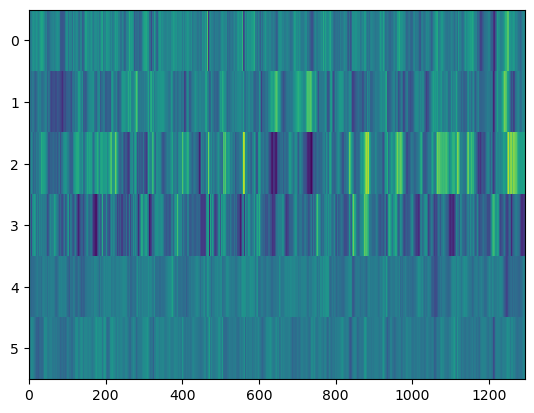

In [185]:
sample_x, sample_y = librosa.load(sample_file)

tntz = calculate_tonnetz(sample_x, sample_y)
plt.imshow(tntz , interpolation='nearest', aspect='auto')
plt.show()

## Full Ten Genre Model

In [122]:
genres = all_gtzan_genres
#

In [123]:
labels, features = parse_genres(genres, gtzan_directory)
#

Calculating features for pop... (1/10)
Calculating features for metal... (2/10)
Calculating features for disco... (3/10)
Calculating features for blues... (4/10)
Calculating features for reggae... (5/10)
Calculating features for classical... (6/10)
Calculating features for rock... (7/10)
Calculating features for hiphop... (8/10)
Calculating features for country... (9/10)
Calculating features for jazz... (10/10)

 ~ Genre calculations complete ~


In [141]:
features_train, features_val, \
  features_test, labels_train, \
  labels_val, labels_test = train_test_validation(labels, features)

In [180]:
train_mean, val_mean, test_mean = model_iterations(15, features, features_train, labels_train,
                                       features_val, labels_val, features_test, labels_test)

Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 16.6970 - sparse_categorical_accuracy: 0.1107 - val_loss: 2.7605 - val_sparse_categorical_accuracy: 0.2812
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.6946 - sparse_categorical_accuracy: 0.2453 - val_loss: 2.4634 - val_sparse_categorical_accuracy: 0.2937
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6646 - sparse_categorical_accuracy: 0.2589 - val_loss: 2.0034 - val_sparse_categorical_accuracy: 0.3500
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2636 - sparse_categorical_accuracy: 0.2929 - val_loss: 2.1027 - val_sparse_categorical_accuracy: 0.3187
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1772 - sparse_categorical_accuracy: 0.3180 - val_loss: 1.9547 - val_sparse_categorical_accuracy: 0.3375
Epoch 6/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2006 - sparse_categorical_accuracy: 0.3162 - val_loss: 1.9698 - val_sparse_categorical_accuracy: 0.3375
Epoch 7/40
40/4

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4069 - sparse_categorical_accuracy: 0.6179 
Validation Accuracy: 57.5%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4628 - sparse_categorical_accuracy: 0.5697 
Testing Accuracy: 56.0%
Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.0738 - sparse_categorical_accuracy: 0.0854 - val_loss: 3.1455 - val_sparse_categorical_accuracy: 0.1688
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4714 - sparse_categorical_accuracy: 0.1698 - val_loss: 2.7574 - val_sparse_categorical_accuracy: 0.2188
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8446 - sparse_categorical_accuracy: 0.2439 - val_loss: 2.2574 - val_sparse_categorical_accuracy: 0.2625
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4090 - sparse_categorical_accuracy: 0.2758 - val_loss: 2.2119 - val_sparse_categorical_accuracy: 0.2937
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1811 - sparse_categorical_accuracy: 0.3078 - val_l

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6069 - sparse_categorical_accuracy: 0.7939  
Training Accuracy: 78.87%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5674 - sparse_categorical_accuracy: 0.5470 
Validation Accuracy: 51.88%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2914 - sparse_categorical_accuracy: 0.5707 
Testing Accuracy: 56.5%
Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.3926 - sparse_categorical_accuracy: 0.0918 - val_loss: 3.2899 - val_sparse_categorical_accuracy: 0.2688
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2114 - sparse_categorical_accuracy: 0.2291 - val_loss: 2.5080 - val_sparse_categorical_accuracy: 0.2937
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9538 - sparse_categorical_accuracy: 0.2476 - val_loss: 2.8028 - val_sparse_categorical_accuracy: 0.2562
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4820 - sparse_categorical_accuracy: 0.2546 - val_loss: 2.1396 - val_sparse_categorical_accur

Epoch 40/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0547 - sparse_categorical_accuracy: 0.6281 - val_loss: 1.4900 - val_sparse_categorical_accuracy: 0.5813
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6280 - sparse_categorical_accuracy: 0.7769 
Training Accuracy: 78.09%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.4225 - sparse_categorical_accuracy: 0.5978
Validation Accuracy: 58.13%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0210 - sparse_categorical_accuracy: 0.6961 
Testing Accuracy: 67.0%
Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 14.3618 - sparse_categorical_accuracy: 0.0846 - val_loss: 3.0473 - val_sparse_categorical_accuracy: 0.2500
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8291 - sparse_categorical_accuracy: 0.1912 - val_loss: 2.4981 - val_sparse_categorical_accuracy: 0.2688
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8015 - sparse_categorical_accuracy: 0.2497 - val_loss: 2.2270 - val_sparse_categorical_accur

Epoch 39/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0646 - sparse_categorical_accuracy: 0.6264 - val_loss: 1.5789 - val_sparse_categorical_accuracy: 0.5500
Epoch 40/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0336 - sparse_categorical_accuracy: 0.6362 - val_loss: 1.5944 - val_sparse_categorical_accuracy: 0.5688
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5984 - sparse_categorical_accuracy: 0.8036 
Training Accuracy: 80.13%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4272 - sparse_categorical_accuracy: 0.5872 
Validation Accuracy: 56.88%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3126 - sparse_categorical_accuracy: 0.5996 
Testing Accuracy: 60.5%
Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 13.6119 - sparse_categorical_accuracy: 0.1093 - val_loss: 2.9762 - val_sparse_categorical_accuracy: 0.2562
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1422 - sparse_categorical_accuracy: 0.2389 - val_loss: 2.5822 - val_sparse_categorical_accu

Epoch 38/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0329 - sparse_categorical_accuracy: 0.6300 - val_loss: 1.6595 - val_sparse_categorical_accuracy: 0.6000
Epoch 39/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0339 - sparse_categorical_accuracy: 0.6505 - val_loss: 1.6469 - val_sparse_categorical_accuracy: 0.5437
Epoch 40/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8675 - sparse_categorical_accuracy: 0.6915 - val_loss: 1.8379 - val_sparse_categorical_accuracy: 0.4938
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5401 - sparse_categorical_accuracy: 0.8021  
Training Accuracy: 80.91%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7309 - sparse_categorical_accuracy: 0.4988 
Validation Accuracy: 49.38%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2244 - sparse_categorical_accuracy: 0.6085 
Testing Accuracy: 58.0%
Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 14.3018 - sparse_categorical_accuracy: 0.0863 - val_loss: 2.7547 - val_sparse_categorical_ac

Epoch 37/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0757 - sparse_categorical_accuracy: 0.6295 - val_loss: 1.6490 - val_sparse_categorical_accuracy: 0.5688
Epoch 38/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9910 - sparse_categorical_accuracy: 0.6494 - val_loss: 1.6980 - val_sparse_categorical_accuracy: 0.5437
Epoch 39/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0672 - sparse_categorical_accuracy: 0.6294 - val_loss: 1.5774 - val_sparse_categorical_accuracy: 0.5500
Epoch 40/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8548 - sparse_categorical_accuracy: 0.7117 - val_loss: 1.7239 - val_sparse_categorical_accuracy: 0.5125
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5721 - sparse_categorical_accuracy: 0.7986 
Training Accuracy: 79.97%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6703 - sparse_categorical_accuracy: 0.5033 
Validation Accuracy: 51.25%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4077 - sparse_categorical_accuracy: 0.6345 
Testing Ac

Epoch 36/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0481 - sparse_categorical_accuracy: 0.6740 - val_loss: 1.5916 - val_sparse_categorical_accuracy: 0.5500
Epoch 37/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1427 - sparse_categorical_accuracy: 0.6301 - val_loss: 1.6310 - val_sparse_categorical_accuracy: 0.5562
Epoch 38/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0208 - sparse_categorical_accuracy: 0.6485 - val_loss: 1.5096 - val_sparse_categorical_accuracy: 0.5875
Epoch 39/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9338 - sparse_categorical_accuracy: 0.6777 - val_loss: 1.7779 - val_sparse_categorical_accuracy: 0.5312
Epoch 40/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9962 - sparse_categorical_accuracy: 0.6559 - val_loss: 1.5708 - val_sparse_categorical_accuracy: 0.5938
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4802 - sparse_categorical_accuracy: 0.8737 
Training Accuracy: 85.6%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4508 - spa

Epoch 35/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0730 - sparse_categorical_accuracy: 0.6200 - val_loss: 1.7081 - val_sparse_categorical_accuracy: 0.5250
Epoch 36/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1503 - sparse_categorical_accuracy: 0.5950 - val_loss: 1.6796 - val_sparse_categorical_accuracy: 0.4812
Epoch 37/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0731 - sparse_categorical_accuracy: 0.6088 - val_loss: 1.6762 - val_sparse_categorical_accuracy: 0.4938
Epoch 38/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0029 - sparse_categorical_accuracy: 0.6523 - val_loss: 1.9310 - val_sparse_categorical_accuracy: 0.4750
Epoch 39/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1530 - sparse_categorical_accuracy: 0.6620 - val_loss: 1.4794 - val_sparse_categorical_accuracy: 0.5063
Epoch 40/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0203 - sparse_categorical_accuracy: 0.6676 - val_loss: 1.6270 - val_sparse_categorical_accuracy: 0.5312
20/20 ━━━━

Epoch 34/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1518 - sparse_categorical_accuracy: 0.6169 - val_loss: 1.4023 - val_sparse_categorical_accuracy: 0.5562
Epoch 35/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0885 - sparse_categorical_accuracy: 0.6369 - val_loss: 1.4373 - val_sparse_categorical_accuracy: 0.5375
Epoch 36/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1051 - sparse_categorical_accuracy: 0.6163 - val_loss: 1.5001 - val_sparse_categorical_accuracy: 0.5813
Epoch 37/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9895 - sparse_categorical_accuracy: 0.6719 - val_loss: 1.6143 - val_sparse_categorical_accuracy: 0.5500
Epoch 38/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1072 - sparse_categorical_accuracy: 0.6621 - val_loss: 1.7809 - val_sparse_categorical_accuracy: 0.5188
Epoch 39/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9901 - sparse_categorical_accuracy: 0.6792 - val_loss: 1.7543 - val_sparse_categorical_accuracy: 0.5063
Epoch 40/4

Epoch 33/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1523 - sparse_categorical_accuracy: 0.6221 - val_loss: 1.5538 - val_sparse_categorical_accuracy: 0.5250
Epoch 34/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0710 - sparse_categorical_accuracy: 0.6540 - val_loss: 1.6694 - val_sparse_categorical_accuracy: 0.5125
Epoch 35/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0456 - sparse_categorical_accuracy: 0.6437 - val_loss: 1.5456 - val_sparse_categorical_accuracy: 0.5437
Epoch 36/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1019 - sparse_categorical_accuracy: 0.6208 - val_loss: 1.4603 - val_sparse_categorical_accuracy: 0.5500
Epoch 37/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1407 - sparse_categorical_accuracy: 0.6307 - val_loss: 1.7243 - val_sparse_categorical_accuracy: 0.5312
Epoch 38/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8313 - sparse_categorical_accuracy: 0.6921 - val_loss: 1.3790 - val_sparse_categorical_accuracy: 0.5813
Epoch 39/4

Epoch 32/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0260 - sparse_categorical_accuracy: 0.6330 - val_loss: 1.9007 - val_sparse_categorical_accuracy: 0.5125
Epoch 33/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1424 - sparse_categorical_accuracy: 0.6118 - val_loss: 1.7619 - val_sparse_categorical_accuracy: 0.5312
Epoch 34/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0582 - sparse_categorical_accuracy: 0.6593 - val_loss: 1.6272 - val_sparse_categorical_accuracy: 0.4938
Epoch 35/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0401 - sparse_categorical_accuracy: 0.6450 - val_loss: 1.6708 - val_sparse_categorical_accuracy: 0.5500
Epoch 36/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9963 - sparse_categorical_accuracy: 0.6716 - val_loss: 1.8988 - val_sparse_categorical_accuracy: 0.6125
Epoch 37/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0561 - sparse_categorical_accuracy: 0.6699 - val_loss: 1.7571 - val_sparse_categorical_accuracy: 0.5250
Epoch 38/4

Epoch 31/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0966 - sparse_categorical_accuracy: 0.6095 - val_loss: 1.5680 - val_sparse_categorical_accuracy: 0.5125
Epoch 32/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0665 - sparse_categorical_accuracy: 0.6461 - val_loss: 1.6716 - val_sparse_categorical_accuracy: 0.4938
Epoch 33/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2240 - sparse_categorical_accuracy: 0.6299 - val_loss: 1.5879 - val_sparse_categorical_accuracy: 0.5188
Epoch 34/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0111 - sparse_categorical_accuracy: 0.6625 - val_loss: 1.6993 - val_sparse_categorical_accuracy: 0.5500
Epoch 35/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0254 - sparse_categorical_accuracy: 0.6550 - val_loss: 1.5603 - val_sparse_categorical_accuracy: 0.5375
Epoch 36/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0116 - sparse_categorical_accuracy: 0.6694 - val_loss: 1.6944 - val_sparse_categorical_accuracy: 0.5188
Epoch 37/4

Epoch 30/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1135 - sparse_categorical_accuracy: 0.5935 - val_loss: 1.5208 - val_sparse_categorical_accuracy: 0.5312
Epoch 31/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3001 - sparse_categorical_accuracy: 0.5701 - val_loss: 1.4900 - val_sparse_categorical_accuracy: 0.5437
Epoch 32/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1889 - sparse_categorical_accuracy: 0.6051 - val_loss: 1.5883 - val_sparse_categorical_accuracy: 0.5625
Epoch 33/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0654 - sparse_categorical_accuracy: 0.6169 - val_loss: 1.8241 - val_sparse_categorical_accuracy: 0.5625
Epoch 34/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0999 - sparse_categorical_accuracy: 0.6340 - val_loss: 1.8586 - val_sparse_categorical_accuracy: 0.5000
Epoch 35/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1944 - sparse_categorical_accuracy: 0.6409 - val_loss: 1.6705 - val_sparse_categorical_accuracy: 0.5188
Epoch 36/4

Epoch 29/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1584 - sparse_categorical_accuracy: 0.6053 - val_loss: 1.6603 - val_sparse_categorical_accuracy: 0.5125
Epoch 30/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1507 - sparse_categorical_accuracy: 0.5675 - val_loss: 1.5212 - val_sparse_categorical_accuracy: 0.5312
Epoch 31/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1587 - sparse_categorical_accuracy: 0.5985 - val_loss: 1.6043 - val_sparse_categorical_accuracy: 0.5312
Epoch 32/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1818 - sparse_categorical_accuracy: 0.5814 - val_loss: 1.5155 - val_sparse_categorical_accuracy: 0.5125
Epoch 33/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2181 - sparse_categorical_accuracy: 0.5769 - val_loss: 1.5716 - val_sparse_categorical_accuracy: 0.5125
Epoch 34/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1728 - sparse_categorical_accuracy: 0.6224 - val_loss: 1.6262 - val_sparse_categorical_accuracy: 0.4938
Epoch 35/4

Epoch 28/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2013 - sparse_categorical_accuracy: 0.5738 - val_loss: 1.7630 - val_sparse_categorical_accuracy: 0.4875
Epoch 29/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0483 - sparse_categorical_accuracy: 0.6176 - val_loss: 1.7782 - val_sparse_categorical_accuracy: 0.4500
Epoch 30/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0492 - sparse_categorical_accuracy: 0.6324 - val_loss: 1.5772 - val_sparse_categorical_accuracy: 0.5188
Epoch 31/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9976 - sparse_categorical_accuracy: 0.6395 - val_loss: 1.6972 - val_sparse_categorical_accuracy: 0.5312
Epoch 32/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0588 - sparse_categorical_accuracy: 0.6768 - val_loss: 1.6351 - val_sparse_categorical_accuracy: 0.5063
Epoch 33/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1876 - sparse_categorical_accuracy: 0.6126 - val_loss: 1.5984 - val_sparse_categorical_accuracy: 0.5063
Epoch 34/4

In [181]:
print(f'Average Training Accuracy: {train_mean*100}% \n \
Average Validation Accuracy: {val_mean*100}% \n \
Average Test Accuracy: {test_mean*100}%')

Average Training Accuracy: 81.0% 
 Average Validation Accuracy: 55.00000000000001% 
 Average Test Accuracy: 59.0%


In [163]:
train_mean, val_mean, test_mean = model_iterations(15, features, features_train, labels_train,
                                       features_val, labels_val, features_test, labels_test, 
                                       batch_size=16, optimizer='rmsprop', 
                                       epochs=40, dense1=100, dense2=80, dense3=80,
                                       dropout1=0.3, dropout2=0.2)

Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 14.0074 - sparse_categorical_accuracy: 0.1284 - val_loss: 3.1600 - val_sparse_categorical_accuracy: 0.2250
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9757 - sparse_categorical_accuracy: 0.2569 - val_loss: 2.8012 - val_sparse_categorical_accuracy: 0.2375
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2547 - sparse_categorical_accuracy: 0.2119 - val_loss: 2.4430 - val_sparse_categorical_accuracy: 0.2250
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4701 - sparse_categorical_accuracy: 0.2722 - val_loss: 2.1415 - val_sparse_categorical_accuracy: 0.3375
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1285 - sparse_categorical_accuracy: 0.3038 - val_loss: 1.9921 - val_sparse_categorical_accuracy: 0.3250
Epoch 6/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1921 - sparse_categorical_accuracy: 0.3075 - val_loss: 2.0979 - val_sparse_categorical_accuracy: 0.3562
Epoch 7/40
40/4

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3285 - sparse_categorical_accuracy: 0.5648 
Validation Accuracy: 52.5%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1717 - sparse_categorical_accuracy: 0.6305 
Testing Accuracy: 62.5%
Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 15.7100 - sparse_categorical_accuracy: 0.1118 - val_loss: 3.9600 - val_sparse_categorical_accuracy: 0.2562
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9956 - sparse_categorical_accuracy: 0.2111 - val_loss: 2.5661 - val_sparse_categorical_accuracy: 0.2688
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8329 - sparse_categorical_accuracy: 0.2480 - val_loss: 2.5503 - val_sparse_categorical_accuracy: 0.2500
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3290 - sparse_categorical_accuracy: 0.3140 - val_loss: 1.8816 - val_sparse_categorical_accuracy: 0.3187
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1799 - sparse_categorical_accuracy: 0.3187 - val_

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9862 - sparse_categorical_accuracy: 0.6796 - val_loss: 1.5982 - val_sparse_categorical_accuracy: 0.5188
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5810 - sparse_categorical_accuracy: 0.7931 
Training Accuracy: 80.13%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5155 - sparse_categorical_accuracy: 0.5596 
Validation Accuracy: 51.88%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1624 - sparse_categorical_accuracy: 0.6362 
Testing Accuracy: 60.0%
Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 16.6579 - sparse_categorical_accuracy: 0.0694 - val_loss: 3.0391 - val_sparse_categorical_accuracy: 0.2375
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0169 - sparse_categorical_accuracy: 0.1961 - val_loss: 2.4063 - val_sparse_categorical_accuracy: 0.3063
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1981 - sparse_categorical_accuracy: 0.2145 - val_loss: 2.1308 - val_sparse_categorical_accuracy: 0.3250


Epoch 39/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1421 - sparse_categorical_accuracy: 0.6206 - val_loss: 1.4382 - val_sparse_categorical_accuracy: 0.5813
Epoch 40/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0267 - sparse_categorical_accuracy: 0.6258 - val_loss: 1.4211 - val_sparse_categorical_accuracy: 0.5562
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6227 - sparse_categorical_accuracy: 0.7691 
Training Accuracy: 77.31%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3722 - sparse_categorical_accuracy: 0.5752 
Validation Accuracy: 55.62%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2005 - sparse_categorical_accuracy: 0.6179 
Testing Accuracy: 59.0%
Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 14.8643 - sparse_categorical_accuracy: 0.0999 - val_loss: 3.0919 - val_sparse_categorical_accuracy: 0.3250
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2197 - sparse_categorical_accuracy: 0.2533 - val_loss: 2.9614 - val_sparse_categorical_accur

Epoch 38/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1292 - sparse_categorical_accuracy: 0.6290 - val_loss: 1.7024 - val_sparse_categorical_accuracy: 0.5500
Epoch 39/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0948 - sparse_categorical_accuracy: 0.6560 - val_loss: 1.6562 - val_sparse_categorical_accuracy: 0.5375
Epoch 40/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1615 - sparse_categorical_accuracy: 0.6499 - val_loss: 1.6545 - val_sparse_categorical_accuracy: 0.5500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5826 - sparse_categorical_accuracy: 0.8032  
Training Accuracy: 80.44%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4698 - sparse_categorical_accuracy: 0.5857
Validation Accuracy: 55.0%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1051 - sparse_categorical_accuracy: 0.6619 
Testing Accuracy: 64.5%
Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.0164 - sparse_categorical_accuracy: 0.0932 - val_loss: 3.2885 - val_sparse_categorical_accu

Epoch 37/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9756 - sparse_categorical_accuracy: 0.6776 - val_loss: 1.5323 - val_sparse_categorical_accuracy: 0.5875
Epoch 38/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0011 - sparse_categorical_accuracy: 0.6899 - val_loss: 1.5446 - val_sparse_categorical_accuracy: 0.5562
Epoch 39/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9142 - sparse_categorical_accuracy: 0.6920 - val_loss: 1.5349 - val_sparse_categorical_accuracy: 0.5875
Epoch 40/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0662 - sparse_categorical_accuracy: 0.6266 - val_loss: 1.3392 - val_sparse_categorical_accuracy: 0.6062
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5697 - sparse_categorical_accuracy: 0.7886  
Training Accuracy: 79.34%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1489 - sparse_categorical_accuracy: 0.6587 
Validation Accuracy: 60.62%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1047 - sparse_categorical_accuracy: 0.6505 
Testing Ac

Epoch 36/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1154 - sparse_categorical_accuracy: 0.6237 - val_loss: 1.7157 - val_sparse_categorical_accuracy: 0.5250
Epoch 37/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0397 - sparse_categorical_accuracy: 0.6561 - val_loss: 1.7822 - val_sparse_categorical_accuracy: 0.5125
Epoch 38/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1163 - sparse_categorical_accuracy: 0.6166 - val_loss: 1.5136 - val_sparse_categorical_accuracy: 0.5063
Epoch 39/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9928 - sparse_categorical_accuracy: 0.6604 - val_loss: 1.6876 - val_sparse_categorical_accuracy: 0.5813
Epoch 40/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1380 - sparse_categorical_accuracy: 0.6615 - val_loss: 1.5169 - val_sparse_categorical_accuracy: 0.5562
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6031 - sparse_categorical_accuracy: 0.8056  
Training Accuracy: 80.75%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5307 - s

Epoch 35/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0662 - sparse_categorical_accuracy: 0.6582 - val_loss: 1.5833 - val_sparse_categorical_accuracy: 0.5625
Epoch 36/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2178 - sparse_categorical_accuracy: 0.5928 - val_loss: 1.6338 - val_sparse_categorical_accuracy: 0.5375
Epoch 37/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9706 - sparse_categorical_accuracy: 0.6399 - val_loss: 1.6219 - val_sparse_categorical_accuracy: 0.5312
Epoch 38/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0317 - sparse_categorical_accuracy: 0.6570 - val_loss: 1.4742 - val_sparse_categorical_accuracy: 0.5875
Epoch 39/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9787 - sparse_categorical_accuracy: 0.6566 - val_loss: 1.5679 - val_sparse_categorical_accuracy: 0.5437
Epoch 40/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1458 - sparse_categorical_accuracy: 0.6296 - val_loss: 1.4294 - val_sparse_categorical_accuracy: 0.6062
20/20 ━━━━

Epoch 34/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1780 - sparse_categorical_accuracy: 0.5967 - val_loss: 1.4122 - val_sparse_categorical_accuracy: 0.5938
Epoch 35/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0547 - sparse_categorical_accuracy: 0.6451 - val_loss: 1.5990 - val_sparse_categorical_accuracy: 0.5375
Epoch 36/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0392 - sparse_categorical_accuracy: 0.6364 - val_loss: 1.4425 - val_sparse_categorical_accuracy: 0.5688
Epoch 37/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0768 - sparse_categorical_accuracy: 0.6332 - val_loss: 1.7180 - val_sparse_categorical_accuracy: 0.5375
Epoch 38/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0481 - sparse_categorical_accuracy: 0.6286 - val_loss: 1.4672 - val_sparse_categorical_accuracy: 0.5625
Epoch 39/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0163 - sparse_categorical_accuracy: 0.6474 - val_loss: 1.4258 - val_sparse_categorical_accuracy: 0.5688
Epoch 40/

Epoch 33/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2492 - sparse_categorical_accuracy: 0.5978 - val_loss: 1.5713 - val_sparse_categorical_accuracy: 0.5625
Epoch 34/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2189 - sparse_categorical_accuracy: 0.6078 - val_loss: 1.4609 - val_sparse_categorical_accuracy: 0.5375
Epoch 35/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0729 - sparse_categorical_accuracy: 0.6486 - val_loss: 1.6232 - val_sparse_categorical_accuracy: 0.5375
Epoch 36/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0761 - sparse_categorical_accuracy: 0.6545 - val_loss: 1.5232 - val_sparse_categorical_accuracy: 0.5375
Epoch 37/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1637 - sparse_categorical_accuracy: 0.5909 - val_loss: 1.5783 - val_sparse_categorical_accuracy: 0.5375
Epoch 38/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0015 - sparse_categorical_accuracy: 0.6703 - val_loss: 1.7009 - val_sparse_categorical_accuracy: 0.5250
Epoch 39/4

Epoch 32/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0738 - sparse_categorical_accuracy: 0.5992 - val_loss: 1.4926 - val_sparse_categorical_accuracy: 0.5938
Epoch 33/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2302 - sparse_categorical_accuracy: 0.5860 - val_loss: 1.6611 - val_sparse_categorical_accuracy: 0.5125
Epoch 34/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0758 - sparse_categorical_accuracy: 0.6225 - val_loss: 1.5559 - val_sparse_categorical_accuracy: 0.5188
Epoch 35/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1349 - sparse_categorical_accuracy: 0.6296 - val_loss: 1.5437 - val_sparse_categorical_accuracy: 0.5437
Epoch 36/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1479 - sparse_categorical_accuracy: 0.6080 - val_loss: 1.5639 - val_sparse_categorical_accuracy: 0.5375
Epoch 37/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0931 - sparse_categorical_accuracy: 0.6518 - val_loss: 1.8047 - val_sparse_categorical_accuracy: 0.5188
Epoch 38/

Epoch 31/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1774 - sparse_categorical_accuracy: 0.5714 - val_loss: 1.5846 - val_sparse_categorical_accuracy: 0.4875
Epoch 32/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0702 - sparse_categorical_accuracy: 0.6412 - val_loss: 1.4795 - val_sparse_categorical_accuracy: 0.5437
Epoch 33/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1171 - sparse_categorical_accuracy: 0.6159 - val_loss: 1.5361 - val_sparse_categorical_accuracy: 0.5188
Epoch 34/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0456 - sparse_categorical_accuracy: 0.6211 - val_loss: 1.5376 - val_sparse_categorical_accuracy: 0.5000
Epoch 35/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0601 - sparse_categorical_accuracy: 0.6408 - val_loss: 1.7752 - val_sparse_categorical_accuracy: 0.4812
Epoch 36/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0628 - sparse_categorical_accuracy: 0.6511 - val_loss: 1.5569 - val_sparse_categorical_accuracy: 0.5125
Epoch 37/

Epoch 30/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2850 - sparse_categorical_accuracy: 0.5640 - val_loss: 1.4675 - val_sparse_categorical_accuracy: 0.5562
Epoch 31/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3066 - sparse_categorical_accuracy: 0.5696 - val_loss: 1.5103 - val_sparse_categorical_accuracy: 0.5188
Epoch 32/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0184 - sparse_categorical_accuracy: 0.6488 - val_loss: 1.6454 - val_sparse_categorical_accuracy: 0.5375
Epoch 33/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0952 - sparse_categorical_accuracy: 0.6084 - val_loss: 1.6009 - val_sparse_categorical_accuracy: 0.5437
Epoch 34/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0277 - sparse_categorical_accuracy: 0.6414 - val_loss: 1.6243 - val_sparse_categorical_accuracy: 0.5750
Epoch 35/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2046 - sparse_categorical_accuracy: 0.6217 - val_loss: 1.7371 - val_sparse_categorical_accuracy: 0.5250
Epoch 36/4

Epoch 29/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2184 - sparse_categorical_accuracy: 0.6169 - val_loss: 1.4160 - val_sparse_categorical_accuracy: 0.6000
Epoch 30/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1685 - sparse_categorical_accuracy: 0.6023 - val_loss: 1.3638 - val_sparse_categorical_accuracy: 0.5562
Epoch 31/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1252 - sparse_categorical_accuracy: 0.6157 - val_loss: 1.4854 - val_sparse_categorical_accuracy: 0.5125
Epoch 32/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0631 - sparse_categorical_accuracy: 0.6303 - val_loss: 1.4388 - val_sparse_categorical_accuracy: 0.5250
Epoch 33/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1039 - sparse_categorical_accuracy: 0.6295 - val_loss: 1.3207 - val_sparse_categorical_accuracy: 0.6000
Epoch 34/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9864 - sparse_categorical_accuracy: 0.6836 - val_loss: 1.3010 - val_sparse_categorical_accuracy: 0.6187
Epoch 35/4

Epoch 28/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2316 - sparse_categorical_accuracy: 0.5809 - val_loss: 1.5271 - val_sparse_categorical_accuracy: 0.5063
Epoch 29/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1229 - sparse_categorical_accuracy: 0.6274 - val_loss: 1.6370 - val_sparse_categorical_accuracy: 0.5437
Epoch 30/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1564 - sparse_categorical_accuracy: 0.6184 - val_loss: 1.5350 - val_sparse_categorical_accuracy: 0.5625
Epoch 31/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2750 - sparse_categorical_accuracy: 0.5812 - val_loss: 1.4487 - val_sparse_categorical_accuracy: 0.5562
Epoch 32/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1943 - sparse_categorical_accuracy: 0.5856 - val_loss: 1.8960 - val_sparse_categorical_accuracy: 0.4812
Epoch 33/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0661 - sparse_categorical_accuracy: 0.6266 - val_loss: 1.5447 - val_sparse_categorical_accuracy: 0.5188
Epoch 34/4

Epoch 27/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2977 - sparse_categorical_accuracy: 0.5784 - val_loss: 1.4812 - val_sparse_categorical_accuracy: 0.5500
Epoch 28/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0988 - sparse_categorical_accuracy: 0.5876 - val_loss: 1.4869 - val_sparse_categorical_accuracy: 0.5500
Epoch 29/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1473 - sparse_categorical_accuracy: 0.6374 - val_loss: 1.3288 - val_sparse_categorical_accuracy: 0.5813
Epoch 30/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9944 - sparse_categorical_accuracy: 0.6399 - val_loss: 1.5342 - val_sparse_categorical_accuracy: 0.5250
Epoch 31/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0780 - sparse_categorical_accuracy: 0.6502 - val_loss: 1.5631 - val_sparse_categorical_accuracy: 0.5125
Epoch 32/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0828 - sparse_categorical_accuracy: 0.6284 - val_loss: 1.4805 - val_sparse_categorical_accuracy: 0.5625
Epoch 33/4

In [164]:
print(f'Average Training Accuracy: {train_mean*100}% \n \
Average Validation Accuracy: {val_mean*100}% \n \
Average Test Accuracy: {test_mean*100}%')

Average Training Accuracy: 81.0% 
 Average Validation Accuracy: 56.00000000000001% 
 Average Test Accuracy: 61.0%


In [151]:
#74%
